### Import Libraries

In [236]:
import configparser as configparser
import pandas as pd
import pymongo
import math
import matplotlib.pyplot as plt
import numpy as np

## Parsing INI File

### Funtion: To parse INI file

In [92]:
def parse_ini(section: str) -> dict:
    """
    This function parses ini file for configuration details
    :param section: section to read from ini
    :return: Dictionary of config details
    """
    config = dict()
    parser = configparser.ConfigParser()
    parser.read("imdb_database.ini")
    if parser.has_section(section):
        config_items = parser.items(section)
        for item in config_items:
            config[item[0]] = item[1]
    return config

In [93]:
mongo_config = parse_ini("mongodb")
mongo_config

{'host': 'localhost', 'database': 'imdb2', 'port': '27017'}

## KMeans Clustering using StartYear and avgRating for specific genres

### Connecting to IMDB MongoDB

In [94]:
connection_string = "mongodb://" + mongo_config['host'] + ":" + mongo_config['port']
mongo_client = pymongo.MongoClient(connection_string)
imdb = mongo_client[mongo_config['database']]
imdb

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'imdb2')

In [95]:
movie_collection = imdb['Movies']
centroid_collection = imdb['Centroids']

### Upsert Centroids

In [96]:
def update_centroids(centroids: list) -> bool:
    requests = []
    id = 1
    for data in centroids:
        filter = {'_id': id}
        update = dict()
        update['startYear'] = data['startYear']
        update['avgRating'] = data['avgRating']
        if bool(update):
            requests += [pymongo.UpdateOne(filter=filter, update={'$set': update}, upsert=True)]
            id += 1
    output = centroid_collection.bulk_write(requests)
    # Checking Convergence of Centroids
    if output.bulk_api_result['nModified'] == 0 and output.bulk_api_result['nUpserted'] == 0:
        return False
    return True


def fetch_centroids() -> list:
    cursor = centroid_collection.find()
    centroids = list(cursor)
    return centroids

### Select k random documents from genre g

In [97]:
def sample_centroids(k: int, g: str) -> bool:
    centroid_collection.drop()
    cursor = movie_collection.aggregate([
            {
                "$match" : {
                    "$and" : [
                        {
                            'kmeansNorm': { '$exists': True },
                            "genres" : g
                        }
                    ]
                }
            }, 
            {
                "$sample" : { "size" : k }
            }, 
            {
                "$project" : {
                    "_id" : 0,
                    "startYear" : { "$first": "$kmeansNorm" },
                    "avgRating" : { "$last": "$kmeansNorm" }
                }
            }
        ])
    centroids = list(cursor)
    return update_centroids(centroids)

### Calculate Eucledian Distance and Closest Centroid

In [98]:
def calculate_euclidean_distance(point: dict, centroid: dict):
    return math.sqrt(((point['kmeansNorm'][0] - centroid['startYear']) ** 2) + ((point['kmeansNorm'][1] - centroid['avgRating']) ** 2))
    

def closest_centroid(point: dict, centroids: list) -> dict:
    min_distance = math.inf
    cluster_centroid = dict()
    for centroid in centroids:
        distance = calculate_euclidean_distance(point, centroid)
        if min_distance > distance:
            min_distance = distance
            cluster_centroid = centroid
    return cluster_centroid

### Fetch Movies for genre g

In [99]:
def fetch_movies(g: str) -> list:
    cursor = movie_collection.aggregate([
            {
                "$match" : {
                    "$and" : [
                        {
                            'kmeansNorm': { '$exists': True },
                            "genres" : g
                        }
                    ]
                }
            },
            {
                "$project" : {
                    "_id" : 1,
                    "kmeansNorm" : 1,
                    "cluster": 1
                }
            }
        ]
    )
    movies = list(cursor)
    return movies

def calculate_new_centroids(g: str) -> list:
    cursor = movie_collection.aggregate([
            {
                "$match" : {
                    "$and" : [
                        {
                            'kmeansNorm': { '$exists': True },
                            "genres" : g
                        }
                    ]
                }
            },
            {
                "$group": {
                    "_id": "$cluster",
                    "startYear": { "$avg": { "$first": "$kmeansNorm" } },
                    "avgRating": { "$avg": { "$last": "$kmeansNorm" } }
                }
            }
        ]
    )
    centroids = list(cursor)
    return centroids

In [100]:
k = 10
g = 'Action'
sample_centroids(k, g)

True

In [101]:
movies = fetch_movies(g)
movies

[{'_id': 14429,
  'kmeansNorm': [0.07407407407407407, 0.8255813953488372],
  'cluster': 5},
 {'_id': 15163,
  'kmeansNorm': [0.08333333333333333, 0.7674418604651163],
  'cluster': 5},
 {'_id': 15324,
  'kmeansNorm': [0.08333333333333333, 0.8372093023255813],
  'cluster': 5},
 {'_id': 17925,
  'kmeansNorm': [0.10185185185185185, 0.8255813953488372],
  'cluster': 5},
 {'_id': 18578,
  'kmeansNorm': [0.1111111111111111, 0.7674418604651163],
  'cluster': 5},
 {'_id': 19421,
  'kmeansNorm': [0.12037037037037036, 0.7906976744186046],
  'cluster': 5},
 {'_id': 21079,
  'kmeansNorm': [0.14814814814814814, 0.7209302325581396],
  'cluster': 5},
 {'_id': 23238,
  'kmeansNorm': [0.1574074074074074, 0.7093023255813954],
  'cluster': 5},
 {'_id': 23427,
  'kmeansNorm': [0.1574074074074074, 0.7790697674418605],
  'cluster': 5},
 {'_id': 26174,
  'kmeansNorm': [0.18518518518518517, 0.7790697674418605],
  'cluster': 5},
 {'_id': 29843,
  'kmeansNorm': [0.21296296296296297, 0.8023255813953489],
  'clust

In [102]:
centroids = fetch_centroids()
centroids

[{'_id': 1, 'avgRating': 0.7790697674418605, 'startYear': 1.0},
 {'_id': 2, 'avgRating': 0.7906976744186046, 'startYear': 0.9814814814814815},
 {'_id': 3, 'avgRating': 0.6511627906976744, 'startYear': 0.6851851851851852},
 {'_id': 4, 'avgRating': 0.6162790697674418, 'startYear': 0.7777777777777778},
 {'_id': 5, 'avgRating': 0.6627906976744187, 'startYear': 0.6481481481481481},
 {'_id': 6, 'avgRating': 0.6046511627906977, 'startYear': 0.9166666666666666},
 {'_id': 7, 'avgRating': 0.8023255813953489, 'startYear': 0.7592592592592593},
 {'_id': 8, 'avgRating': 0.5, 'startYear': 0.8981481481481481},
 {'_id': 9, 'avgRating': 0.7558139534883721, 'startYear': 0.6388888888888888},
 {'_id': 10, 'avgRating': 0.5581395348837209, 'startYear': 0.8611111111111112}]

In [103]:
requests = []
for movie in movies:
    cluster_centroid = closest_centroid(movie, centroids)
    filter = {'_id': movie['_id']}
    update = dict()
    update['cluster'] = cluster_centroid['_id']
    requests += [pymongo.UpdateOne(filter=filter, update={'$set': update})]
output = movie_collection.bulk_write(requests)
print(output.bulk_api_result)
movies = fetch_movies(g)
movies

{'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 2564, 'nModified': 2337, 'nRemoved': 0, 'upserted': []}


[{'_id': 14429,
  'kmeansNorm': [0.07407407407407407, 0.8255813953488372],
  'cluster': 9},
 {'_id': 15163,
  'kmeansNorm': [0.08333333333333333, 0.7674418604651163],
  'cluster': 9},
 {'_id': 15324,
  'kmeansNorm': [0.08333333333333333, 0.8372093023255813],
  'cluster': 9},
 {'_id': 17925,
  'kmeansNorm': [0.10185185185185185, 0.8255813953488372],
  'cluster': 9},
 {'_id': 18578,
  'kmeansNorm': [0.1111111111111111, 0.7674418604651163],
  'cluster': 9},
 {'_id': 19421,
  'kmeansNorm': [0.12037037037037036, 0.7906976744186046],
  'cluster': 9},
 {'_id': 21079,
  'kmeansNorm': [0.14814814814814814, 0.7209302325581396],
  'cluster': 9},
 {'_id': 23238,
  'kmeansNorm': [0.1574074074074074, 0.7093023255813954],
  'cluster': 9},
 {'_id': 23427,
  'kmeansNorm': [0.1574074074074074, 0.7790697674418605],
  'cluster': 9},
 {'_id': 26174,
  'kmeansNorm': [0.18518518518518517, 0.7790697674418605],
  'cluster': 9},
 {'_id': 29843,
  'kmeansNorm': [0.21296296296296297, 0.8023255813953489],
  'clust

In [104]:
centroids = calculate_new_centroids(g)
update_centroids(centroids)
centroids = fetch_centroids()
centroids

[{'_id': 1, 'avgRating': 0.7757223396758282, 'startYear': 0.9276795735129069},
 {'_id': 2, 'avgRating': 0.7161733615221988, 'startYear': 0.9753086419753085},
 {'_id': 3, 'avgRating': 0.6197640908786275, 'startYear': 0.7850891237058384},
 {'_id': 4, 'avgRating': 0.6415041260315079, 'startYear': 0.5910244922341696},
 {'_id': 5, 'avgRating': 0.5509791921664626, 'startYear': 0.8445906432748538},
 {'_id': 6, 'avgRating': 0.617579559363525, 'startYear': 0.6927997076023392},
 {'_id': 7, 'avgRating': 0.4369015047879617, 'startYear': 0.9025735294117647},
 {'_id': 8, 'avgRating': 0.7619990103908956, 'startYear': 0.5122800105069608},
 {'_id': 9, 'avgRating': 0.6294607792917393, 'startYear': 0.9261570674933376},
 {'_id': 10, 'avgRating': 0.779495921100694, 'startYear': 0.8037618770603064}]

### K-Means Algorithm Program for movies with genre g

In [108]:
def sum_of_squared_error(movies: list, centroids):
    sum = 0
    for movie in movies:
        cluster_center = centroids[movie['cluster'] - 1]
        squared_error = calculate_euclidean_distance(movie, cluster_center) ** 2
        sum += squared_error
    return sum

In [118]:
def kmeans(k: int, g: str) -> float:
    sample_centroids(k, g)
    movies = fetch_movies(g)
    centroids = fetch_centroids()
    for loop in range(100):
        requests = []
        for movie in movies:
            cluster_centroid = closest_centroid(movie, centroids)
            filter = {'_id': movie['_id']}
            update = dict()
            update['cluster'] = cluster_centroid['_id']
            requests += [pymongo.UpdateOne(filter=filter, update={'$set': update})]
        output = movie_collection.bulk_write(requests)
        new_centroids = calculate_new_centroids(g)
        cluster_convergence = True
        for centroid in new_centroids:
            if centroid not in centroids:
                cluster_convergence = False
                break
        if cluster_convergence:
           break
        update_centroids(new_centroids)
        centroids = fetch_centroids()
    print(loop)
    return sum_of_squared_error(fetch_movies(g), centroids)


In [119]:
genres = ["Action", "Horror", "Romance", "Sci-Fi", "Thriller"]
kmin = 10
kmax = 50
kstep = 5
kmeans_clusters = dict()
for genre in genres:
    kmeans_clusters[genre] = []
    kmeans_clusters[genre].append([])
    kmeans_clusters[genre].append([])


In [120]:
for genre in genres:
    for k in range(kmin, kmax + 1, kstep):
        kmeans_clusters[genre][0].append(k)
        sse = kmeans(k, genre)
        kmeans_clusters[genre][1].append(sse)
        
kmeans_clusters

67
33
33
42
22
38
61
26
24
28
28
22
26
20
20
16
22
30
30
25
48
29
17
16
18
22
26
17
11
21
15
20
23
20
30
17
19
48
32
18
29
16
35
17
34


{'Action': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [11.260104683147953,
   7.386613057609812,
   5.5799872748258315,
   4.358590087107644,
   3.8555533086857254,
   3.2758152759947556,
   2.885668182927748,
   2.657238005195268,
   2.4605626570002657]],
 'Horror': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [6.601099669562077,
   3.8860894559223635,
   2.9585886056990587,
   2.5878745863426693,
   2.125455734124968,
   1.7832353004021797,
   1.5185124640170375,
   1.5674601334399496,
   1.3401501265061164]],
 'Romance': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [6.947383514845227,
   4.689249334168913,
   3.7484559265657205,
   3.0956507750901467,
   2.7055094167964384,
   2.284687382885618,
   2.015809394542816,
   1.6812636404011836,
   1.4870651573549711]],
 'Sci-Fi': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [3.808233504079276,
   2.5143341910505828,
   1.9389163960055686,
   1.8969313168514526,
   1.7261065867085743,
   1.0836300778796821,
   0.920802575703398,
   0.852921357096039,
 

In [121]:
kmeans_clusters

{'Action': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [11.260104683147953,
   7.386613057609812,
   5.5799872748258315,
   4.358590087107644,
   3.8555533086857254,
   3.2758152759947556,
   2.885668182927748,
   2.657238005195268,
   2.4605626570002657]],
 'Horror': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [6.601099669562077,
   3.8860894559223635,
   2.9585886056990587,
   2.5878745863426693,
   2.125455734124968,
   1.7832353004021797,
   1.5185124640170375,
   1.5674601334399496,
   1.3401501265061164]],
 'Romance': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [6.947383514845227,
   4.689249334168913,
   3.7484559265657205,
   3.0956507750901467,
   2.7055094167964384,
   2.284687382885618,
   2.015809394542816,
   1.6812636404011836,
   1.4870651573549711]],
 'Sci-Fi': [[10, 15, 20, 25, 30, 35, 40, 45, 50],
  [3.808233504079276,
   2.5143341910505828,
   1.9389163960055686,
   1.8969313168514526,
   1.7261065867085743,
   1.0836300778796821,
   0.920802575703398,
   0.852921357096039,
 

## SSE vs Clusters Plot for each genre

Text(0.5, 1.0, 'Movies of Genre: Action')

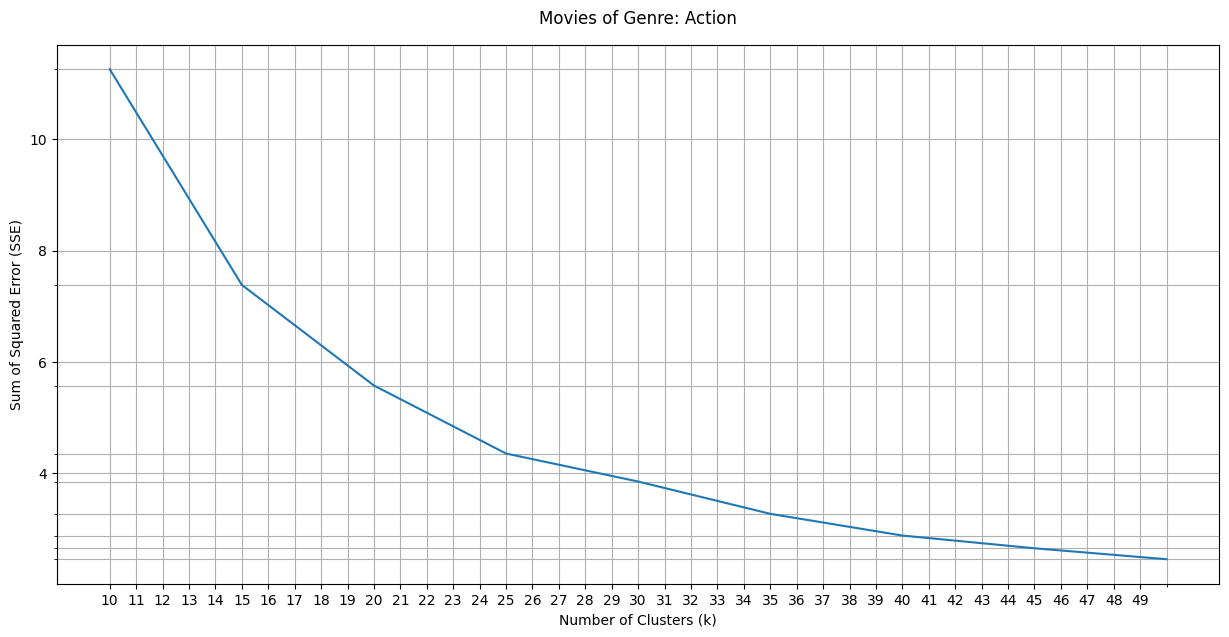

In [219]:
genre = 'Action'
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(kmeans_clusters[genre][0], kmeans_clusters[genre][1])
plt.xticks(np.arange(min(kmeans_clusters[genre][0]), max(kmeans_clusters[genre][0]), step=1))
plt.xticks(kmeans_clusters[genre][0], minor=True)
plt.yticks(kmeans_clusters[genre][1], minor=True)
plt.grid(which='minor', alpha=1)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Error (SSE)")
plt.title("Movies of Genre: " + genre, pad=15)

Text(0.5, 1.0, 'Movies of Genre: Horror')

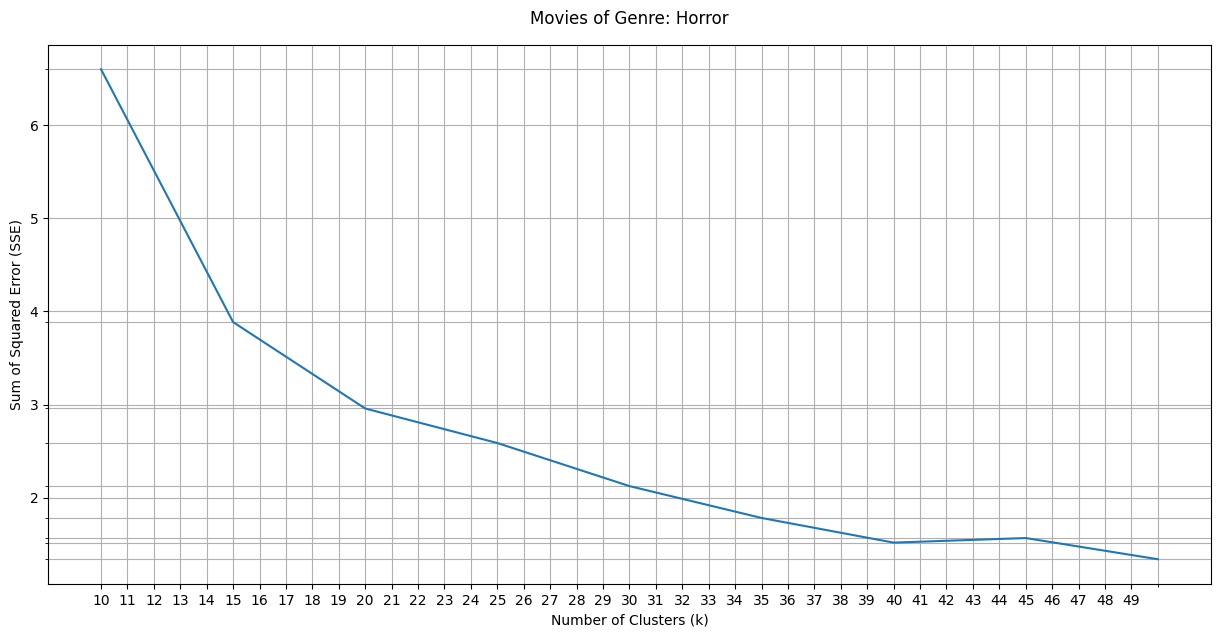

In [221]:
genre = 'Horror'
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(kmeans_clusters[genre][0], kmeans_clusters[genre][1])
plt.xticks(np.arange(min(kmeans_clusters[genre][0]), max(kmeans_clusters[genre][0]), step=1))
plt.xticks(kmeans_clusters[genre][0], minor=True)
plt.yticks(kmeans_clusters[genre][1], minor=True)
plt.grid(which='minor', alpha=1)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Error (SSE)")
plt.title("Movies of Genre: " + genre, pad=15)

Text(0.5, 1.0, 'Movies of Genre: Romance')

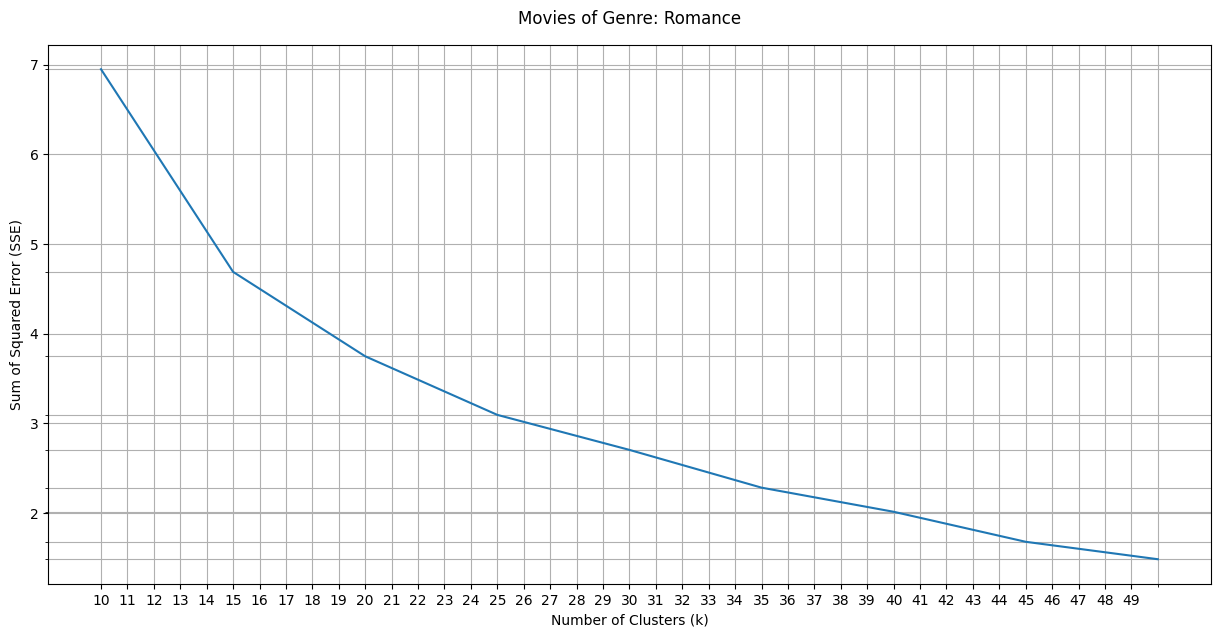

In [223]:
genre = 'Romance'
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(kmeans_clusters[genre][0], kmeans_clusters[genre][1])
plt.xticks(np.arange(min(kmeans_clusters[genre][0]), max(kmeans_clusters[genre][0]), step=1))
plt.xticks(kmeans_clusters[genre][0], minor=True)
plt.yticks(kmeans_clusters[genre][1], minor=True)
plt.grid(which='minor', alpha=1)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Error (SSE)")
plt.title("Movies of Genre: " + genre, pad=15)

Text(0.5, 1.0, 'Movies of Genre: Sci-Fi')

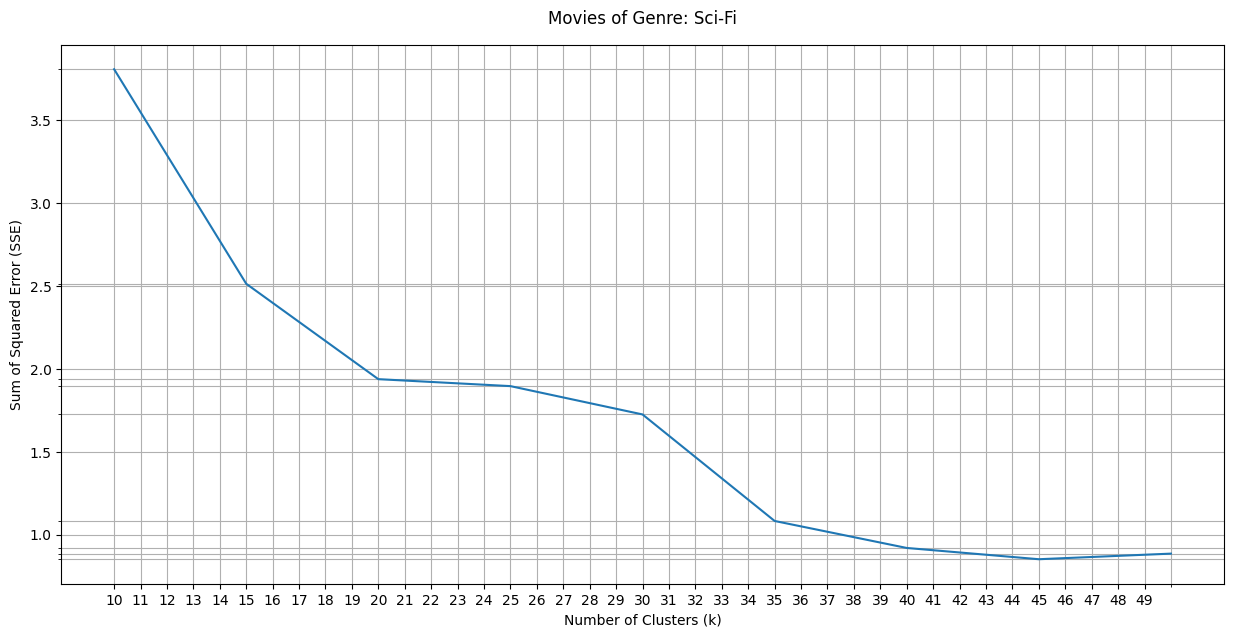

In [225]:
genre = 'Sci-Fi'
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(kmeans_clusters[genre][0], kmeans_clusters[genre][1])
plt.xticks(np.arange(min(kmeans_clusters[genre][0]), max(kmeans_clusters[genre][0]), step=1))
plt.xticks(kmeans_clusters[genre][0], minor=True)
plt.yticks(kmeans_clusters[genre][1], minor=True)
plt.grid(which='minor', alpha=1)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Error (SSE)")
plt.title("Movies of Genre: " + genre, pad=15)

Text(0.5, 1.0, 'Movies of Genre: Thriller')

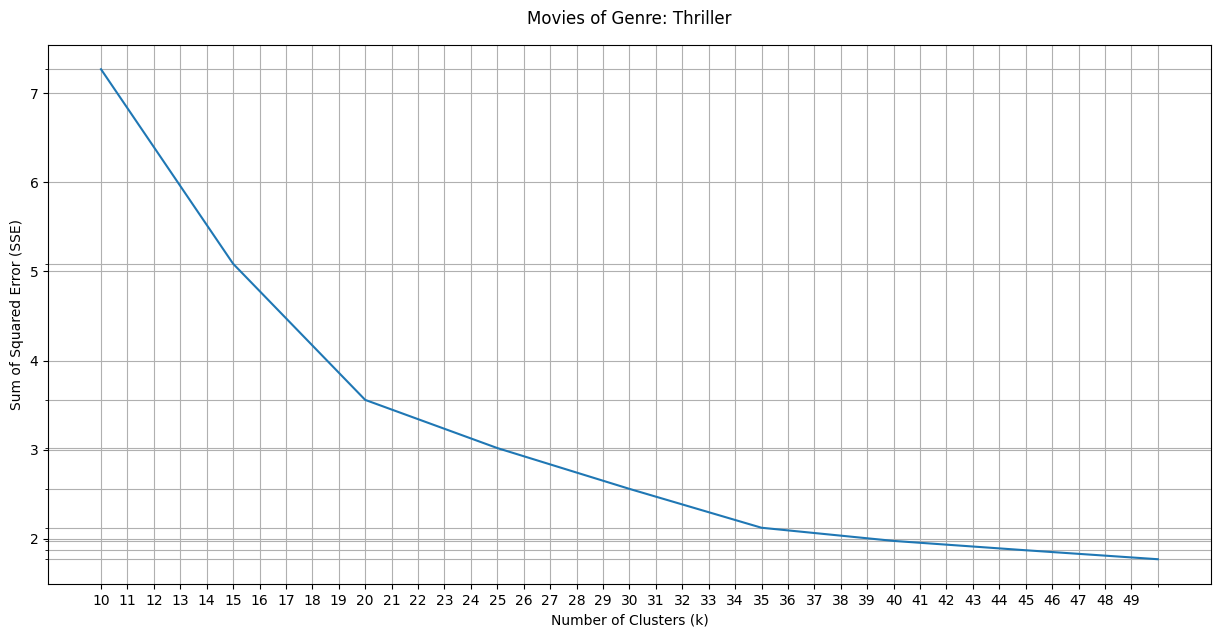

In [227]:
genre = 'Thriller'
plt.figure(figsize=(15,7))
plt.grid()
plt.plot(kmeans_clusters[genre][0], kmeans_clusters[genre][1])
plt.xticks(np.arange(min(kmeans_clusters[genre][0]), max(kmeans_clusters[genre][0]), step=1))
plt.xticks(kmeans_clusters[genre][0], minor=True)
plt.yticks(kmeans_clusters[genre][1], minor=True)
plt.grid(which='minor', alpha=1)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Error (SSE)")
plt.title("Movies of Genre: " + genre, pad=15)

## Best K Cluster for each genre

In [229]:
def get_cluster(g: str) -> dict():
    cursor = movie_collection.aggregate([
            {
                "$match" : {
                    "$and" : [
                        {
                            'kmeansNorm': { '$exists': True },
                            "genres" : g
                        }
                    ]
                }
            },
            {
                "$group": {
                    "_id": "$cluster",
                    "startYear": { "$push": "$startYear" },
                    "avgRating": { "$push": "$avgRating" }
                }
            }
        ]
    )
    clusters = list(cursor)
    return clusters

50


C:\Users\anura\AppData\Local\Temp\ipykernel_54140\2830585424.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", k + 1)
C:\Users\anura\AppData\Local\Temp\ipykernel_54140\2830585424.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))


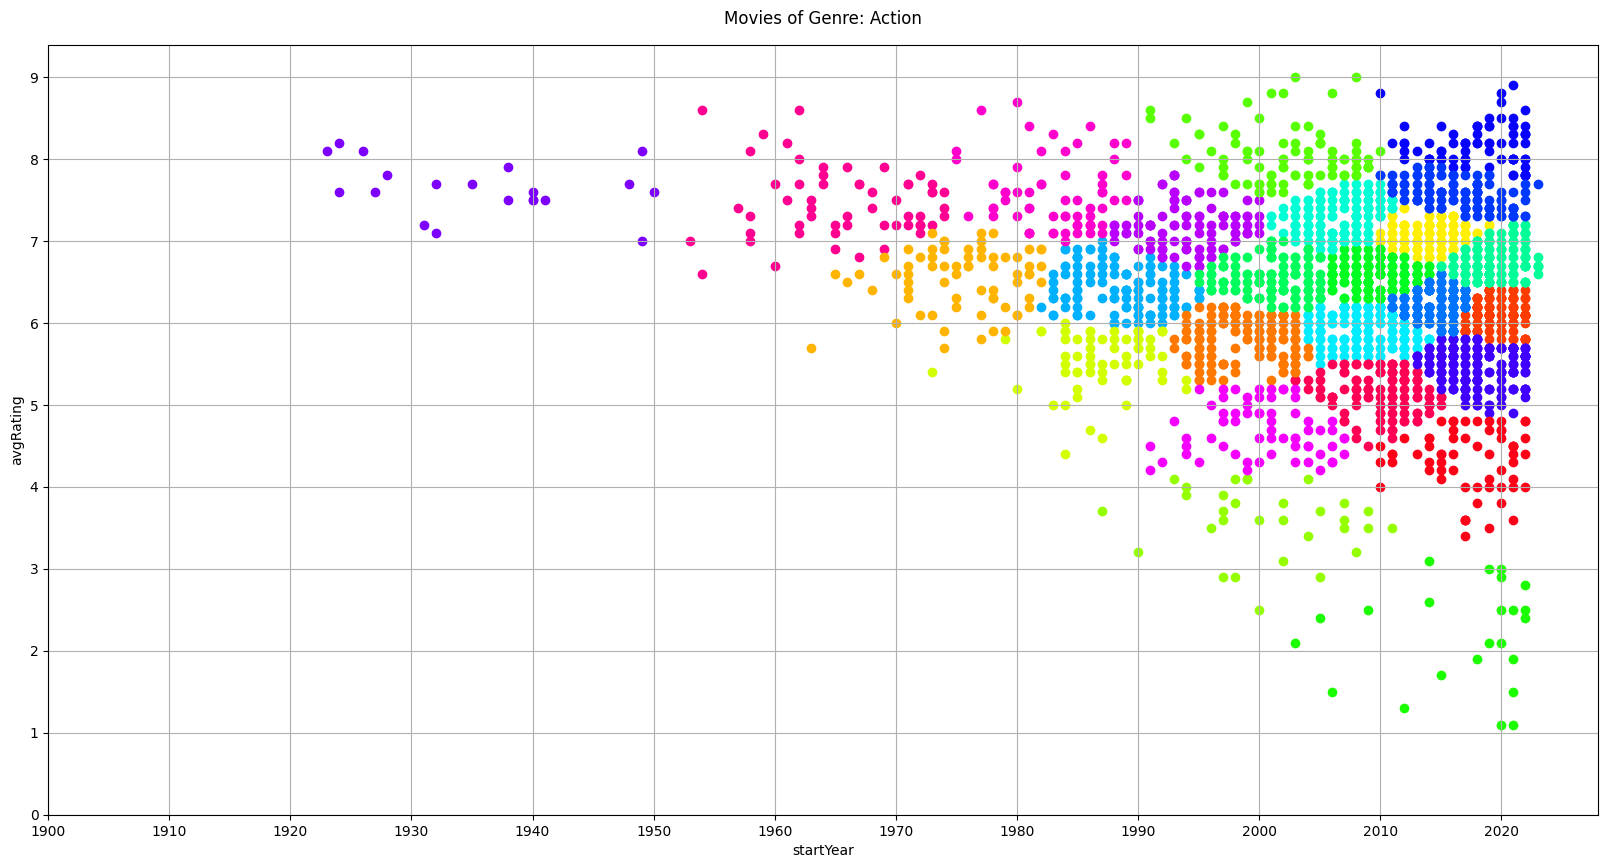

In [243]:
k = 25
genre = 'Action'
kmeans(k, genre)
clusters = get_cluster(genre)
cmap = plt.cm.get_cmap("hsv", k + 1)
plt.figure(figsize=(20,10))
plt.grid()
for cluster in clusters:
    plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))
plt.xticks(np.arange(1900, 2023, step=10))
plt.yticks(np.arange(0, 10, step=1))
plt.xlabel("startYear")
plt.ylabel("avgRating")
plt.title("Movies of Genre: " + genre, pad=15)
plt.show()

35


C:\Users\anura\AppData\Local\Temp\ipykernel_54140\423949616.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", k + 1)
C:\Users\anura\AppData\Local\Temp\ipykernel_54140\423949616.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))


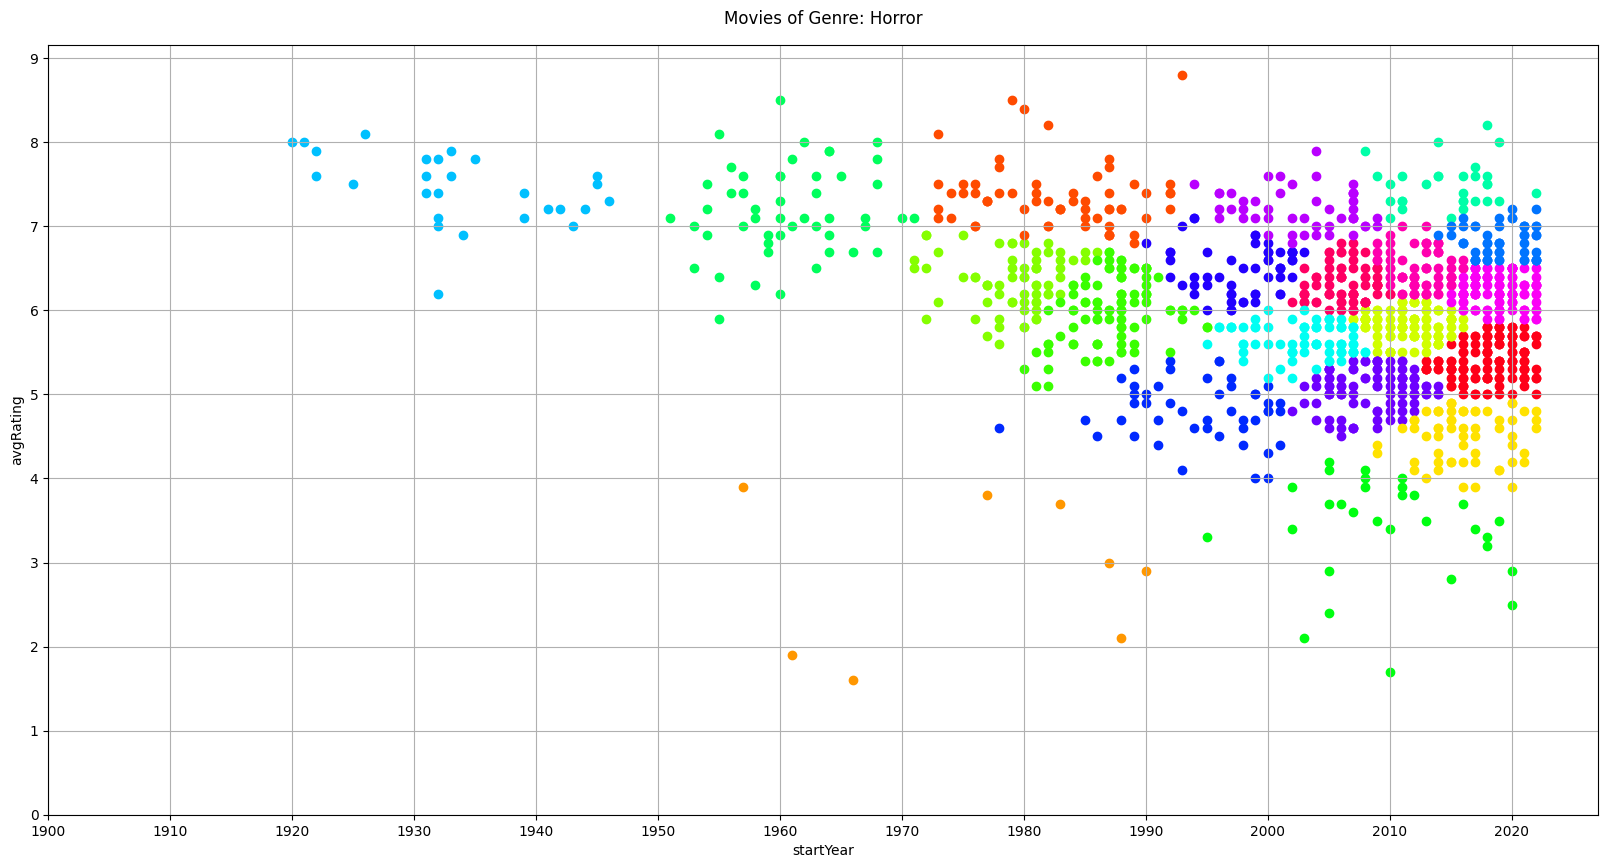

In [244]:
k = 20
genre = 'Horror'
kmeans(k, genre)
clusters = get_cluster(genre)
cmap = plt.cm.get_cmap("hsv", k + 1)
plt.figure(figsize=(20,10))
plt.grid()
for cluster in clusters:
    plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))
plt.xticks(np.arange(1900, 2023, step=10))
plt.yticks(np.arange(0, 10, step=1))
plt.xlabel("startYear")
plt.ylabel("avgRating")
plt.title("Movies of Genre: " + genre, pad=15)
plt.show()

41


C:\Users\anura\AppData\Local\Temp\ipykernel_54140\2770255808.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", k + 1)
C:\Users\anura\AppData\Local\Temp\ipykernel_54140\2770255808.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))


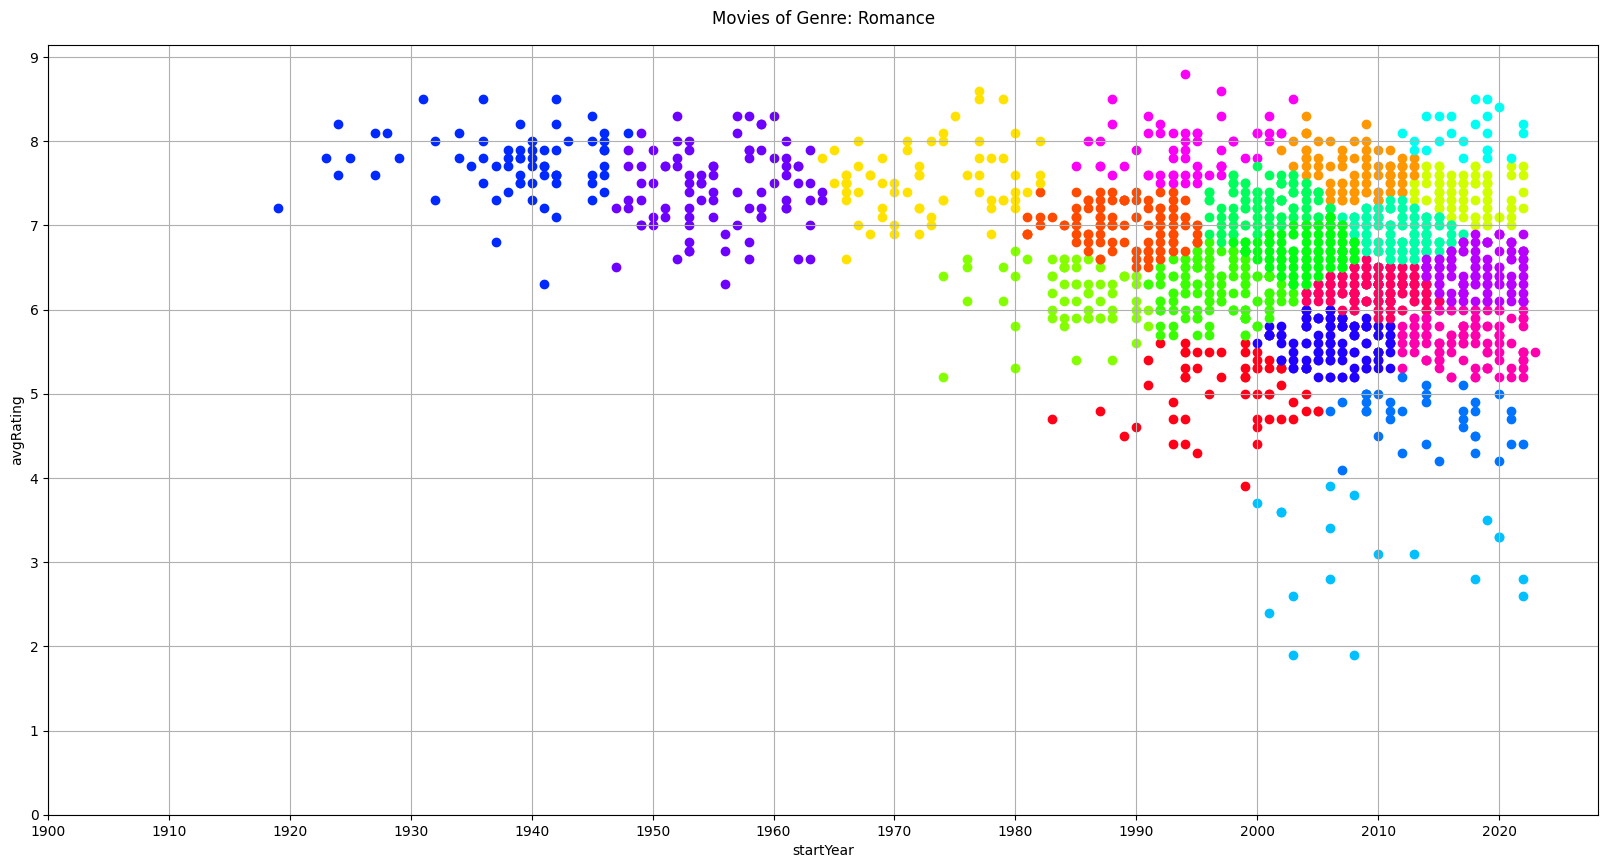

In [245]:
k = 20
genre = 'Romance'
kmeans(k, genre)
clusters = get_cluster(genre)
cmap = plt.cm.get_cmap("hsv", k + 1)
plt.figure(figsize=(20,10))
plt.grid()
for cluster in clusters:
    plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))
plt.xticks(np.arange(1900, 2023, step=10))
plt.yticks(np.arange(0, 10, step=1))
plt.xlabel("startYear")
plt.ylabel("avgRating")
plt.title("Movies of Genre: " + genre, pad=15)
plt.show()

23


C:\Users\anura\AppData\Local\Temp\ipykernel_54140\1723834936.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", k + 1)
C:\Users\anura\AppData\Local\Temp\ipykernel_54140\1723834936.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))


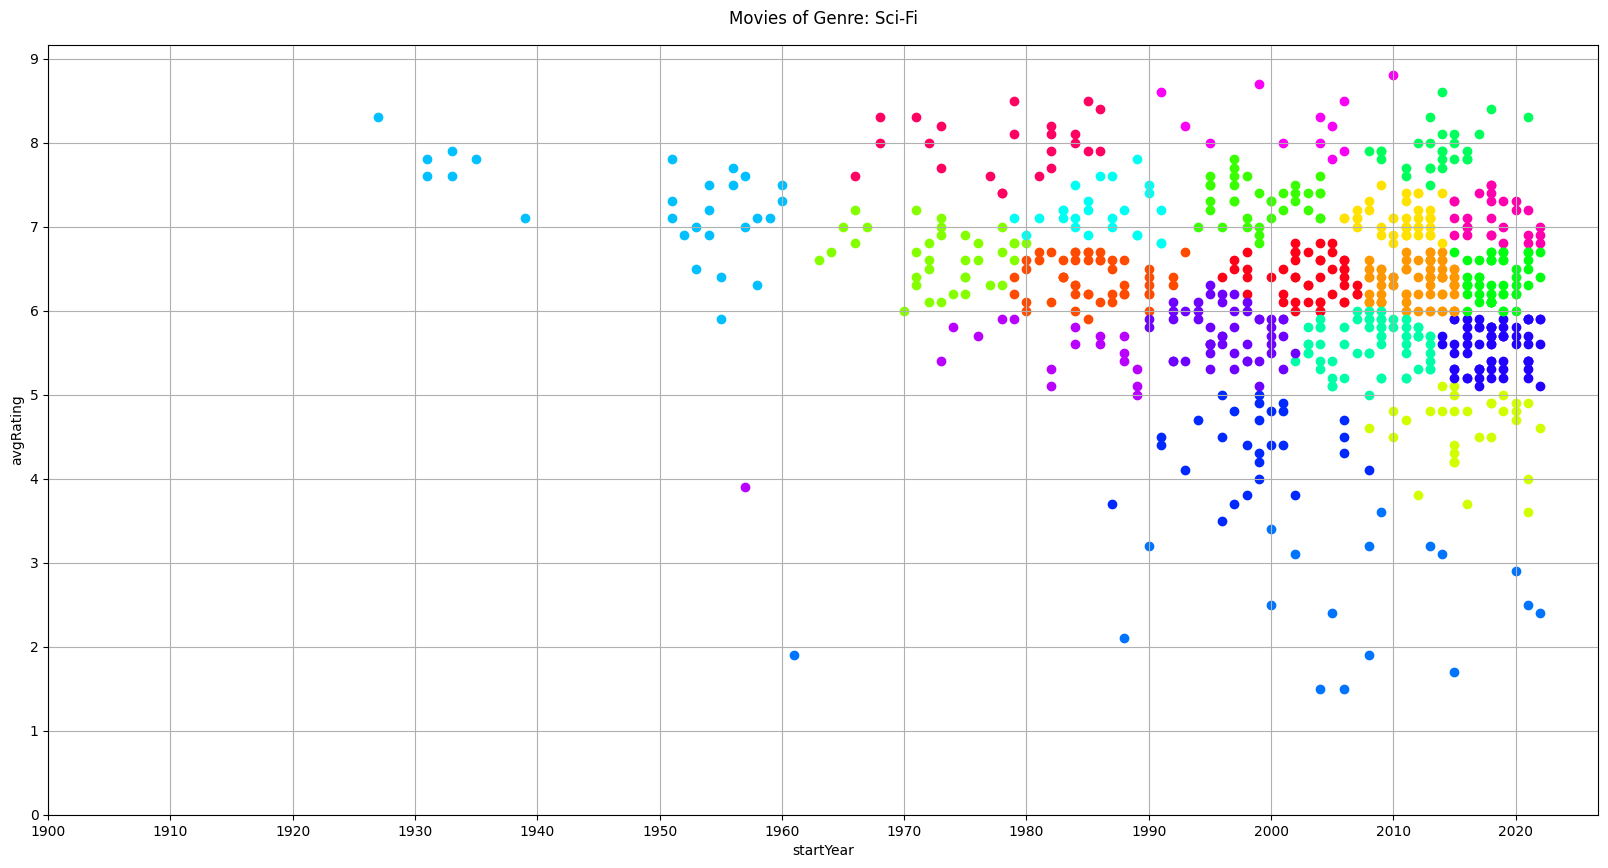

In [246]:
k = 20
genre = 'Sci-Fi'
kmeans(k, genre)
clusters = get_cluster(genre)
cmap = plt.cm.get_cmap("hsv", k + 1)
plt.figure(figsize=(20,10))
plt.grid()
for cluster in clusters:
    plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))
plt.xticks(np.arange(1900, 2023, step=10))
plt.yticks(np.arange(0, 10, step=1))
plt.xlabel("startYear")
plt.ylabel("avgRating")
plt.title("Movies of Genre: " + genre, pad=15)
plt.show()

14


C:\Users\anura\AppData\Local\Temp\ipykernel_54140\941277955.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", k + 1)
C:\Users\anura\AppData\Local\Temp\ipykernel_54140\941277955.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))


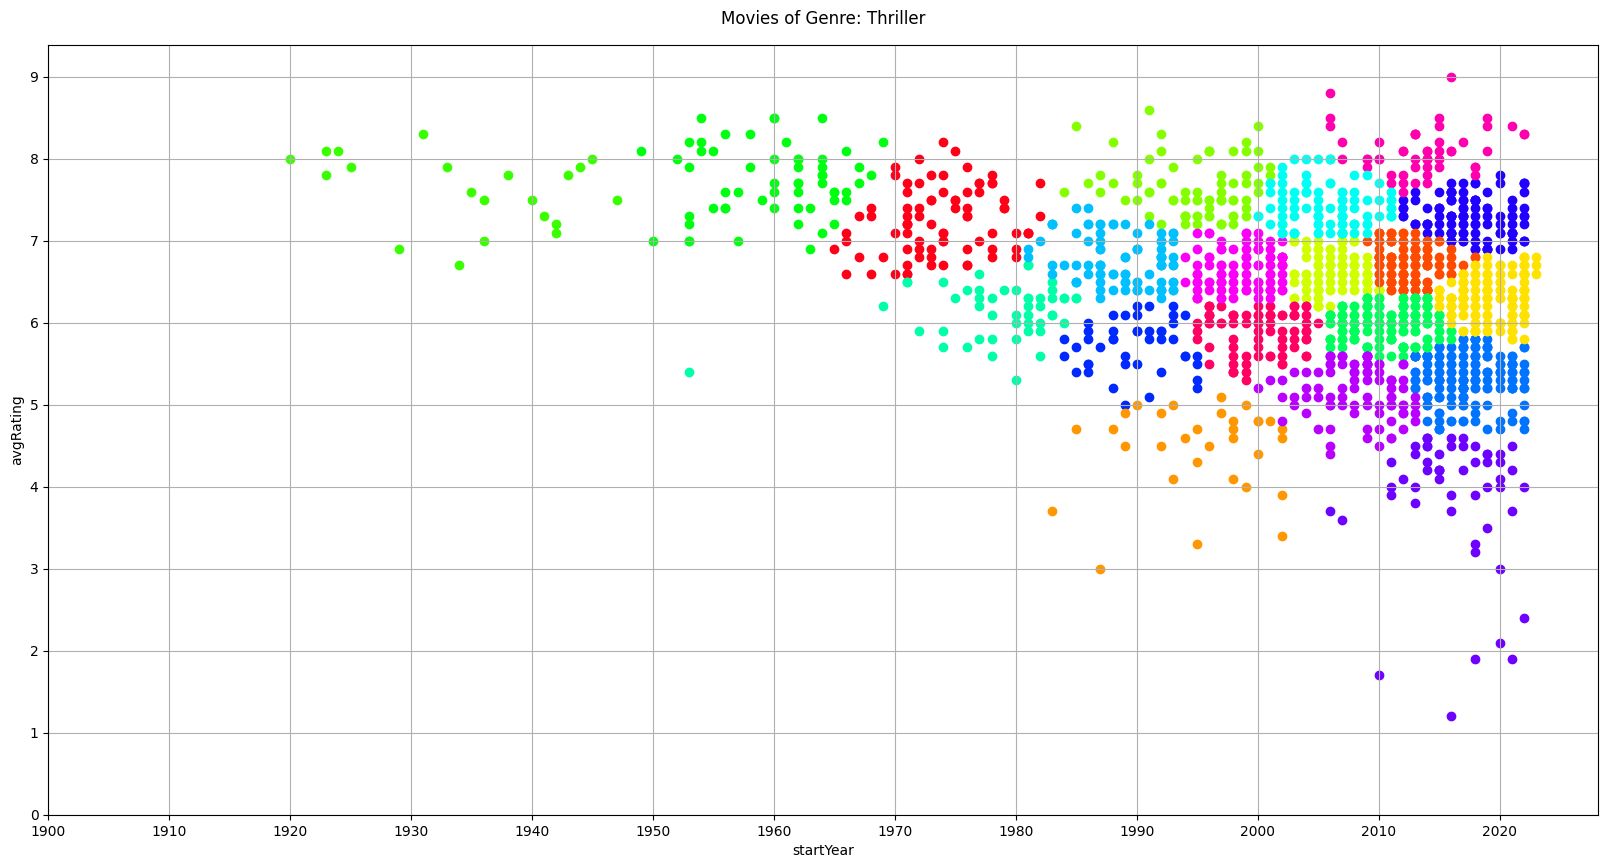

In [247]:
k = 20
genre = 'Thriller'
kmeans(k, genre)
clusters = get_cluster(genre)
cmap = plt.cm.get_cmap("hsv", k + 1)
plt.figure(figsize=(20,10))
plt.grid()
for cluster in clusters:
    plt.scatter(cluster['startYear'], cluster['avgRating'], c=cmap(cluster['_id']))
plt.xticks(np.arange(1900, 2023, step=10))
plt.yticks(np.arange(0, 10, step=1))
plt.xlabel("startYear")
plt.ylabel("avgRating")
plt.title("Movies of Genre: " + genre, pad=15)
plt.show()